In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [3]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [4]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [5]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [6]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,IN0065000287,0,2018-11-02 10:45:48.677,4307,Dr chaminda bandara,Uva Province,Badulla,Badulla�,101,Asanga Peiris,13,Prabaharan Agencies,187,Brethin Syrup 60ml,10.0,163.20,186.00,0.0,0.0,1632.0,2018,November,11,2,6,Friday,10
1,IN0065000287,0,2018-11-02 10:45:48.677,4307,Dr chaminda bandara,Uva Province,Badulla,Badulla�,101,Asanga Peiris,13,Prabaharan Agencies,187,Brethin Syrup 60ml,0.0,163.20,186.00,1.0,1.0,0.0,2018,November,11,2,6,Friday,10
2,IN0066000105,0,2018-11-02 14:55:18.963,2533,Union Pharmacy,Southern Province,Matara,Dickwella,104,Praneeth Waruna,14,Unichemist Distributor,269,Adclear Face Wash 60gm,5.0,1188.60,1355.00,0.0,0.0,5943.0,2018,November,11,2,6,Friday,14
3,CSO011701382,54,2018-11-02 15:53:20.543,349,SITHUMINA PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,3,Futop Cream 5gm,6.0,308.55,351.75,0.0,0.0,1851.3,2018,November,11,2,6,Friday,15
4,CSO011701382,54,2018-11-02 15:53:20.543,349,SITHUMINA PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,94,Thermoseal R.A. 50gm,3.0,256.20,292.00,0.0,0.0,768.6,2018,November,11,2,6,Friday,15


### Select the most selling product

In [7]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Sec_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [8]:
Sec_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
19,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,Western Province,Gampaha,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,15
20,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,Western Province,Gampaha,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,0.0,216.7,247.0,3.0,3.0,0.0,2018,November,11,2,6,Friday,15
89,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,Southern Province,Galle,Batapola,92,Chathura Desun,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,10
90,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,Southern Province,Galle,Batapola,92,Chathura Desun,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,2,6,Friday,10
172,CSO009201190,110,2018-11-02 08:42:13.637,3284,Queens Pharmacy,Southern Province,Galle,Batapola,92,Chathura Desun,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,8


In [9]:
#Aggregate data into weekly sum
sample=Sec_invoice_All[['Date','UnitQty','FreeQty','FreeCompanyQty']]
weekly=sample.resample('W', on='Date').sum()

In [10]:
#sum free quantities
column_names = ['FreeQty','FreeCompanyQty']
weekly['Free_Total']= weekly[column_names].sum(axis=1)

In [11]:
weekly

,UnitQty,FreeQty,FreeCompanyQty,Free_Total
Date,,,,
2018-11-04,307.0,84.0,88.0,172.0
2018-11-11,7505.0,1992.0,2239.0,4231.0
2018-11-18,5488.0,1607.0,1635.0,3242.0
2018-11-25,5944.0,1714.0,1769.0,3483.0
2018-12-02,18655.0,5258.0,5521.0,10779.0
...,...,...,...,...
2020-02-02,11494.0,3250.0,3385.0,6635.0
2020-02-09,1554.0,449.0,482.0,931.0
2020-02-16,6313.0,2068.0,2086.0,4154.0


In [12]:
weekly = weekly.reset_index()

Text(0.5, 1.0, 'Total products and free products by Week')

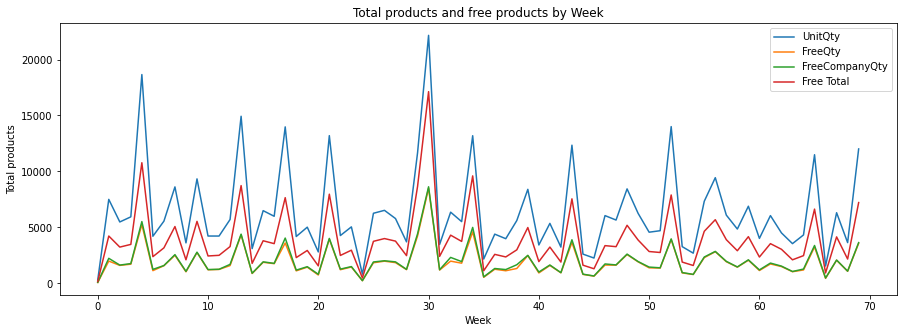

In [15]:
plt.plot(weekly.UnitQty)
plt.plot(weekly.FreeQty)
plt.plot(weekly.FreeCompanyQty)
plt.plot(weekly.Free_Total)
plt.legend(['UnitQty', 'FreeQty' , 'FreeCompanyQty' , 'Free Total'])
plt.rcParams['figure.figsize'] = [15, 5]
plt.xlabel("Week")
plt.ylabel("Total products")
plt.title("Total products and free products by Week")

In [14]:
weekly.corr(method ='pearson')

,UnitQty,FreeQty,FreeCompanyQty,Free_Total
UnitQty,1.000000,0.98008,0.981897,0.981440
FreeQty,0.980080,1.00000,0.998220,0.999540
FreeCompanyQty,0.981897,0.99822,1.000000,0.999569
Free_Total,0.981440,0.99954,0.999569,1.000000
